In [1]:
"""Cleaning tools

This script contains all tools for cleaning text for modelling.
In eda_tools.py, we also have scrub_it_clean, but the tools here
have be used exclusively for the modelling.

There are different functions which are import to distiquish:

    1.  clean() which is the most basic clean that we
        have done. This removes most things, but has problems with
        websites, html, and also the masking tokens introduced at
        deID stage before the data reaches us.
    2.  advanced_clean() is the more advanced cleaning form, which
        does most of the same cleaning as clean(), with the addition
        of being able to:
        - replace masked tokens with something meaningful i.e. <fname>
        with john
        - clean emails and websites
        - replace abbrevations like pt with patient
        - remove website links and emails.
    3.  split_into_sentences() does exactly that, and tries to split
        larger ammounts of text into logical sentneces. This is useful
        for cases where we want to do first sentence only, or match each
        sentence.

There are also some functions which help with the replacement of tokens
and abbreviations.

Still todo:
    1. N/A

"""

'Cleaning tools\n\nThis script contains all tools for cleaning text for modelling.\nIn eda_tools.py, we also have scrub_it_clean, but the tools here\nhave be used exclusively for the modelling.\n\nThere are different functions which are import to distiquish:\n\n    1.  clean() which is the most basic clean that we\n        have done. This removes most things, but has problems with\n        websites, html, and also the masking tokens introduced at\n        deID stage before the data reaches us.\n    2.  advanced_clean() is the more advanced cleaning form, which\n        does most of the same cleaning as clean(), with the addition\n        of being able to:\n        - replace masked tokens with something meaningful i.e. <fname>\n        with john\n        - clean emails and websites\n        - replace abbrevations like pt with patient\n        - remove website links and emails.\n    3.  split_into_sentences() does exactly that, and tries to split\n        larger ammounts of text into log

In [2]:
import re
from typing import List
from pathlib import Path
import pandas as pd
import numpy as np

In [3]:
def clean(text: str) -> str:
    """Clean text so it is in a standardized form in most basic way

    Parameters
    ----------
    text : str
        dirty text, as a string

    Returns
    -------
    str
        clean text, as a string, taking the form of:
        - lower case
        - common short forms replaced
        - domain specific abvreviations replaced to match EP text
        - common abbreviation replaced
        - symbols and puntuation removed

    """

    # convert words to lower case, split, and rejoin them with space
    text = " ".join(text.lower().split())

    # common short forms expanded
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)

    # symbols and punctuations
    text = re.sub(r", ", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    # text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    # text = re.sub(r":", " : ", text)
    text = re.sub(r"\$", " dollar ", text)
    text = re.sub(r"\%", " percent ", text)
    text = re.sub(r"\&", " and ", text)

    # abbreviations
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" i e ", " ie ", text)
    text = re.sub(r" e t c ", " etc ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)

    # common trips
    text = re.sub(r"note: ", "", text)

    return text

In [4]:
def split_into_sentences(text: str) -> List[str]:
    """Splits a string into list where each entry is a sentence

    Parameters
    ----------
    text : str
        previously cleaned lower case text which can be broken into sentences

    Returns
    -------
    List[str]
        a list where each entry is a sentence in the form of str,
        and we have cleaned out other text which containes fullstops:
        - websites to have the mask <website>
        - standards in the from XYZ.11.11.11 to be <standard>
    """

    # set out the common replacement shorthands
    alphabets = "([A-Za-z])"
    prefixes = "(mr|st|mrs|ms|dr)[.]"
    suffixes = "(inc|ltd|jr|sr|co)"
    starters = r"(mr|mrs|ms|dr|he\s|she\s|it\s|they\s"
    starters += r"|their\s|our\s|we\s|but\s|however\s|that\s|this\s|wherever)"
    standards = r"([a-z]+\.[0-9]+\.[0-9]+\.[0-9]+)"
    acronyms = "([a-z][.][a-z][.](?:[a-z][.])?)"
    websites = "[.](com|net|org|io|gov)"
    url = r"(https?://\S+)"

    # put a fullstop at the end of paragraph without, i.e. at end of bullet points
    text = text.rstrip()
    if not text.endswith("."):
        text = text + "."

    # clean the text up to make sure its standardised
    text = " " + text + "  "
    text = text.replace(r"\n", " ")

    # replace websites and standards with a mask
    text = re.sub(url, "<website>", text)
    text = re.sub(standards, "<standard-number>", text)

    #
    text = re.sub(r"(?<=\d)\.", "<prd>", text)
    text = re.sub(prefixes, "\\1<prd>", text)
    text = re.sub(websites, "<prd>\\1", text)
    # if "Ph.D" in text:
    #    text = text.replace("Ph.D.", "Ph<prd>D<prd>")
    text = re.sub(r"\s" + alphabets + "[.] ", " \\1<prd> ", text)
    text = re.sub(acronyms + " " + starters, "\\1<stop> \\2", text)
    text = re.sub(
        alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]",
        "\\1<prd>\\2<prd>\\3<prd>",
        text,
    )
    text = re.sub(alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>", text)
    text = re.sub(" " + suffixes + "[.] " + starters, " \\1<stop> \\2", text)
    text = re.sub(" " + suffixes + "[.]", " \\1<prd>", text)
    text = re.sub(" " + alphabets + "[.]", " \\1<prd>", text)

    if "”" in text:
        text = text.replace(".”", "”.")
    if '"' in text:
        text = text.replace('."', '".')
    if "!" in text:
        text = text.replace('!"', '"!')
    if "?" in text:
        text = text.replace('?"', '"?')

    # replace all the sentence ending signifers with a <stop>
    text = text.replace(".", ".<stop>")
    text = text.replace("?", "?<stop>")
    text = text.replace("!", "!<stop>")

    # replace our <prd> holder token with a fullstop
    text = text.replace("<prd>", ".")

    if "<stop>" in text:
        # split on our sentence break <stop>, and clean up
        sentences = text.split("<stop>")
        sentences = sentences[:-1]
        sentences = [s.strip() for s in sentences]
    else:
        sentences = [text.strip()]

    return sentences

In [6]:
#data
comp = pd.read_csv("datafile").dropna()
text= comp['text']

In [7]:
l = np.array(text)
text_clean = [clean(i) for i in l]

In [8]:
text_split = [split_into_sentences(i) for i in text_clean]
# split_into_sentences on a list returns a nested list; unnest list
txt_splt = [item for sublist in text_split for item in sublist]

In [9]:
split_text = pd.DataFrame({"comp_text_split": txt_splt})
split_text.to_csv("split_text.csv")

In [10]:
def load_abbrevation_mapping_dict(mapping_dictionary_path: Path) -> dict:
    """Takes a pointer to a CSV file of abbreviations
     and makes a dictionary for mapping

    Parameters
    ----------
    mapping_dictionary_path : Path
        A Path to a CSV file of abbreviations

    Returns
    -------
    dict
        a dictionary, where the keys are the abbreviations
        and the values are the long form of the abbreviation
    """

    mapping_abbrev_df = pd.read_csv(
        mapping_dictionary_path, encoding="utf-8", delimiter=","
    )

    mapping_abbrev_df["abbrev"] = mapping_abbrev_df.abbrev.str.lower()
    mapping_abbrev_df["long_form"] = mapping_abbrev_df["long_form"].str.lower()

    mapping_abbrev_dict = mapping_abbrev_df.set_index("abbrev").to_dict()["long_form"]

    return mapping_abbrev_dict

In [11]:
def abbrevation_mapping(text: str) -> str:
    """Takes a string of words and replaces abbreviations in the mapping dictionry
     with the long form version

    Parameters
    ----------
    text : str
        a string of words containing abbreviations

    Returns
    -------
    str
        a string with the abbreviations replaced
    """

    mapping_dictionary = {
        "hx": "History",
        "pt": "Patient",
        "HCO": "Healthcare organization",
        "dx": "diagnosis",
        "PAC": "Primary accreditation contact",
        "Admin": "Administrator",
        "h/o": "History of",
        "H&P": "History and physical",
        "ICU": "Intensive Care Unit",
        "Inpt": "inpatient",
        "Outpt": "outpatient",
        "Res": "residential",
        "BT": "building tour",
        "AHC": "Ambulatory Health Care",
        "BHC": "Behavioral Health Care",
        "HAP": "Hospital",
        "OME": "Home Care",
        "DSC": "Disease Specific Care",
        "HCSS": "Health Care Staffing Services",
        "OBS": "Office Based Surgery",
        "LSC": "Life Safety Code",
        "LAB": "Laboratory",
        "L&D": "Labor & Delivery",
        "MBU": "Mother Baby Unit",
        "AAMI": "Association for the Advancement of Medical Instrumentation",
        "AORN": "Associate of PeriOperative Registered Nurses",
        "CDC": "Centers for Disease Control",
        "QD": "Once A Day",
        "BID": "Twice A Day",
        "TID": "Three Times A Day",
        "QID": "Four Times A Day",
        "BP": "Blood Pressure",
        "CBC": "Complete Blood Count",
        "CPAP": "Continuous Positive Airway Pressure",
        "DNR": "Do Not Resuscitate",
        "DVT": "Deep Vein Thrombosis",
        "FX": "Fracture",
        "H&H": "Hemoglobin & Hematocrit",
        "HA": "Headache",
        "HTN": "Hypertension",
        "I&D": "Incision & Drainage",
        "IM": "Intramuscular",
        "SQ": "Subcutaneous",
        "LLQ": "Left Lower Quadrant",
        "LUQ": "Left Upper Quadrant",
        "RLQ": "Right Lower Quadrant",
        "RUQ": "Right Upper Quadrant",
        "N/V": "Nausea & Vomiting",
        "NPO": "Nothing by Mouth",
        "PO": "By Mouth",
        "PRN": "As needed",
        "Q": "Every",
        "R/O": "Rule Out",
        "ROS": "Review of Symptoms",
        "s/p": "Status Post",
        "SOB": "Shortness of Breath",
        "UA": "Urinalysis",
        "VSS": "Vital Signs Stable",
        "Wt": "Weight",
        "IVF": "In Vetro Fertilization",
        "SART": "Society for Assisted Reproductive Technology",
        "POC": "Point of Care",
        "EM": "Electron Microscopy",
        "IFU": "Instructions for Use",
        "IP": "Infection Prevention",
        "QC": "Quality Control",
        "IQCP": "Individualized Quality Control Program",
        "QCP": "Quality Control Plan",
        "DAT": "Direct Antibody Test",
        "PPMP": "Provider Performed Microscopy Procedure",
        "QA": "Quality Assessment",
        "SOP": "Standard Operating Procedure",
        "PCR": "Polymerase Chain Reaction",
        "CLIA": "Clinical Laboratory Improvement Act",
        "LD": "Laboratory Director",
        "CLSI": "Clinical Laboratory Improvement Institute",
        "OPPE": "Ongoing Professional Practice Evaluation",
        "PACU": "post anesthesia recovery unit",
        "RN": "registered nurse",
        "NM": "nurse manager",
        "Dir": "director",
        "ED": "emergency room",
        "DO": "doctor of osteopathy",
        "CRNA": "certified registered nurses assistant",
        "CEO": "chief executive officer",
        "CNO": "chief nursing officer",
        "COO": "chief operating officer",
        "CMO": "chief medical officer",
        "BB": "blood bank",
        "Tx": "treatment",
        "SI": "suicide ideation",
        "C/O": "complains of",
        "HI": "Homicidal ideation",
        "Rx": "medication",
        "2°": "secondary to",
        "≈": "Approximately",
        "~": "Approximately",
        "CC": "Chief complaint",
        "∆": "Changes",
        "H/P": "History and Physical",
        "IOP": "Intensive Outpatient Program",
        "PHP": "Partial hospitalization program",
        "CM": "case management",
        "CSP": "Central Sterile Processing",
        "SPD": "Sterile Processing Department",
        "WO": "work order",
        "AEM": "Alternate Equipment Maintenance",
        "RCA": "Root cause analysis",
        "OEM": "Original equipment manufacture",
        "EID": "Emerging infectious diseases",
        "EUA": "Emergency use authorization",
        "IAW ": "In accordance with",
        "MIFU": "Manufactures instruction for use",
        "LPN": "Licensed Practical Nurse",
        "LVN": "Licensed Vocational Nurse",
        "MD": "Medical Doctor",
        "MS": "Medical Staff",
        "OT": "Occupational Therapist",
        "PT": "Physical Therapist",
        "Pres": "President",
        "RT": "Respiratory Therapist",
        "SLP": "Speech Language Pathologist",
        "Endo": "Endoscopy",
        "OR": "Operating Room",
        "Ped": "Pediatrics",
        "Pedi": "Pediatrics",
        "IV": "Intravenous",
        "mg": "milligrams",
        "HS": "hour of sleep",
        "ER": "Emergency Room",
    }

    # replace in the text
    text = re.sub(
        r"\b" + r"\b|\b".join(mapping_dictionary.keys()) + r"\b",
        lambda m: mapping_dictionary[m.group(0)],
        text,
        flags=re.UNICODE,
    )

    return text

In [12]:
def load_token_mapping_dict(mapping_token_path: Path) -> dict:
    """Takes a pointer to a CSV file of masking tokens and their dummy pairs,
     and makes a dictionary for mapping

    Parameters
    ----------
    mapping_token_path : Path
        path to the csv file

    Returns
    -------
    dict
        dictionary with masking tokens as keys and dummies as values
    """
    mapping_token_df = pd.read_csv(mapping_token_path, encoding="utf-8", delimiter=",")

    mapping_token_df["token"] = mapping_token_df.token.str.lower()
    mapping_token_df["example"] = mapping_token_df["example"].str.lower()

    mapping_token_dict = mapping_token_df.set_index("token").to_dict()["example"]

    return mapping_token_dict

In [13]:
def token_mapping(text: str) -> str:
    """Takes a string of words and replaces tokens that have been
    masked in the de-identification step with some dummy example
    natural text from the mapping dictionary.

    Parameters
    ----------
    text : str
        unprocessed string of words

    Returns
    -------
    str
        processed string of words
    """

    mapping_token_dict = {
        "<tkphone>": "347-850-8899",
        "<tknumberp>": "patient #23078",
        "<tknumbere>": "Serial Number A23991B23",
        "<tknumbero>": "389-94-8505",
        "<tkemail>": "williamsj@jcaho.net",
        "<tkipad>": "192.168.0.1",
        "<tkurl>": "www.jointcommission.org",
        "<tkage>": "92 years old",
        "<tkdatef>": "January 28, 1992",
        "<tkdatemy>": "January 1992",
        "<tkdatemd>": "January 28",
        "<tkdateyo>": "2012",
        "<tkdateyr>": "2012-2014",
        "<tknumbers>": "89748392",
        "<tknamef>": "John",
        "<tknamel>": "Williams",
    }

    # replace in the text
    text = re.sub(
        "|".join(mapping_token_dict.keys()),
        lambda m: mapping_token_dict[m.group(0)],
        text,
    )

    return text

In [14]:
#from leaning_tools import clean, split_into_sentences

import re
import json
import numpy as np
import pandas as pd
from collections import Counter

from typing import List, Union
from pathlib import Path


In [15]:
def get_num_tokens(documents: List[str]) -> np.ndarray:
    
# holding list for the number of tokens in each doc
    token_nums_list = list()
# go through each text in the documents, and split by space
    for document in documents:
        clean_text = clean(document)
        tokens = clean_text.split()
        token_nums_list.append(len(tokens))
# make in to an numpy array
    token_nums_list = np.array(token_nums_list)

    return token_nums_list

In [16]:
def clean(text: str) -> str:
    """Performs a more advanced clean than that done by basic_clean().
    The big changes arethe removal of websites, emails, and standard numbers.
    This function has additionally some replacement of abbreviations and masking tokens.

    Parameters
    ----------
    text : str
        dirty text
    mapping_abbrev_dict : dict
        a mapping dictionary of abbreviations as keys and long forms as values
    mapping_token_dict : dict
        a mapping dictionary of masking tokens as keys and dummy fill ins as values

    Returns
    -------
    str
        clean text
    """

    # replace abbrevations with their full text
    text = abbrevation_mapping(text)

    # set out the common replacement shorthands
    starters = r"(mr|mrs|ms|dr|he\s|she\s|it\s|they\s"
    starters += r"|their\s|our\s|we\s|but\s|however\s|that\s|this\s|wherever)"
    websites = "[.](com|net|org|io|gov)"
    url = r"(https?://\S+)"
    emails = r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b"

    # convert words to lower case, split, and rejoin them with space
    text = " ".join(text.lower().split())

    # replace out plural/singual words with (s) to just be singular
    text = re.sub(r"\(s\)( |\.)", "\\1", text)

    # replace urls, websites and emails with a mask
    text = re.sub(url, "<tkurl>", text)
    text = re.sub(websites, "<tkurl>", text)
    text = re.sub(emails, "<tkemail>", text)

    # common short forms expanded
    text = re.sub(r"’", "'", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)

    # symbols and punctuations
    text = re.sub(r", ", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r"\$", " dollar ", text)
    text = re.sub(r"\%", " percent ", text)
    text = re.sub(r"\&", " and ", text)

    # common trips
    text = re.sub(r"note: ", "", text)

    # put a fullstop at the end of paragraph without, i.e. at end of bullet points
    text = text.rstrip()
    if not text.endswith("."):
        text = text + "."

    # clean the text up to make sure its standardised
    text = " " + text + "  "
    text = text.replace(r"\n", " ")

    # replace standards with short versions of the standard
    standards = r"(\.[0-9]+\.[0-9]+\.[0-9]+)"
    nfpa = r"""(([0-9]+\-[0-9]+:)?(\s[0-9]+[\s-])?\s?
    [^\.][0-9]+\.[0-9]+\.[0-9]+(\.[0-9]+)?(\.[0-9]+)?;?)"""

    text = re.sub(nfpa, "<nfpa>", text)
    text = re.sub("<nfpa>(<nfpa>)+", "standards", text)
    text = re.sub("<nfpa>", "standard", text)

    text = re.sub(standards, " <std>", text)
    text = re.sub("<std>(<std>)+", " standards", text)
    text = re.sub("<std>", " standard", text)

    # replace out fullstop of pc.standard with pc standard
    text = re.sub(r"([a-z]+).standard", "\\1 standard", text)

    # replace the tokens with something more natural
    text = token_mapping(text)

    # remove all non-standard symbols/characters
    text = re.sub(r"[^A-Za-z0-9,.?<>-]", " ", text)

    # replace two or more spaces by a single space
    text = re.sub(r"\s\s+", " ", text)

    return text

In [17]:
def get_num_sentences(documents: List[str]) -> np.ndarray:
    """Get the number of sentences in each document

    Parameters
    ----------
    documents : List[str]
        Each document is a string in the list

    Returns
    -------
    np.ndarray
        An array of interger number of sentences
    """

    # holding list for the num sentences in each doc
    sentence_nums_list = list()

    # go through each text in the documents
    for document in documents:
        clean_text = clean(document)
        sentences = split_into_sentences(clean_text)
        sentence_nums_list.append(len(sentences))

    # make in to an numpy array
    sentence_nums_list = np.array(sentence_nums_list)

    return sentence_nums_list


In [18]:
def scrub_it_clean(text: str) -> str:
    """cleans the text up for word frequency analysis

    Parameters
    ----------
    text : str
        unprocesses text

    Returns
    -------
    str
        text clean of all noise other than words
    """

    # convert words to lower case, split, and rejoin them with space
    text = " ".join(text.lower().split())

    # mask urls
    url = r"(https?://\S+)"
    text = re.sub(url, "<website>", text)

    # give am and pm a tag (later can form back to am/pm)
    text = re.sub(r" a.m. ", " <am> ", text)
    text = re.sub(r" p.m. ", " <pm> ", text)

    # numbers
    text = re.sub(r"[0-9]+", "<num>", text)
    text = re.sub(r"[a-z]+<num>", "<num>", text)
    text = re.sub(r"[a-z]+-<num>", "<num>", text)
    text = re.sub(r"<num>[a-z]+", "<num>", text)
    text = re.sub(r"<num>-[a-z]+", "<num>", text)

    # shortern abvreviations with fullstops to single word
    text = re.sub(r"(?<!\w)([a-z])\.", r"\1", text)

    # mask temperatures like '20°c' and '100°f' or 20 celcius
    # text = re.sub(r'(?<!\w)([0-9])\.', r'\1', text)
    text = re.sub(r"\°c", "<temperature>", text)
    text = re.sub(r"\°f", "<temperature>", text)
    text = re.sub(r"[0-9] celcius", "<temperature>", text)
    text = re.sub(r"[0-9] fahrenheit", "<temperature>", text)

    # mask percentages
    text = re.sub(r"\%", "<percentage>", text)

    # punctuations
    text = " ".join(re.split(r"\/", text))
    text = re.sub(r"\!", "", text)
    text = re.sub(r"\?", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\_", "", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\—", "", text)
    text = re.sub(r"\. ", " ", text)
    text = re.sub(r"\; ", " ", text)

    # quoation marks, apostriphies and 's
    text = re.sub(r"\"", " ", text)
    text = re.sub(r"\’", "'", text)
    text = re.sub(r"\‘", "'", text)
    text = re.sub(r"\`", "", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"s\'", "", text)

    # fractions
    text = re.sub(r"\¼", "", text)
    text = re.sub(r"\¾", "", text)
    text = re.sub(r"\½", "", text)

    # symbols
    text = re.sub(r"[0-9]+\[0-9]+", "", text)
    text = re.sub(r"\^", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\-", " ", text)
    text = re.sub(r"\–", " ", text)
    text = re.sub(r"\—", " ", text)
    text = re.sub(r"\=", "", text)
    text = re.sub(r"\®", "", text)
    text = re.sub(r"\™", "", text)
    text = re.sub(r"\*", "", text)
    text = re.sub(r"\¹", "", text)
    text = re.sub(r"\…", "", text)
    text = re.sub(r"\@", "at", text)
    text = re.sub(r"\•", "", text)
    text = re.sub(r"\·", "", text)
    text = re.sub(r"\›", "", text)
    text = re.sub(r"\§", "", text)
    text = re.sub(r"\±", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\~", "", text)
    text = re.sub(r"\_", "", text)
    text = re.sub(r"\¦", "", text)
    text = re.sub(r"\÷", "", text)

    # brackets
    text = re.sub(r"\(", "", text)
    text = re.sub(r"\)", "", text)
    text = re.sub(r"\[", "", text)
    text = re.sub(r"\]", "", text)
    text = re.sub(r"\{", "", text)
    text = re.sub(r"\}", "", text)
    text = re.sub(r"\(s\)", "", text)

    # mask standards
    standards = r"([a-z]+\.[0-9]+\.[0-9]+\.[0-9]+)"
    text = re.sub(standards, "<standard-number>", text)
    text = re.sub(r"<standard-number>\.", "<standard-number>", text)

    # mask reference codes and section references
    ref_num_2 = r"([0-9]+\.[0-9]+)"
    ref_num_3 = r"([0-9]+\.[0-9]+\.[0-9]+)"
    ref_num_4 = r"([0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)"
    ref_num_5 = r"([0-9]+\.[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)"
    text = re.sub(ref_num_5, r"<ref-number>", text)
    text = re.sub(ref_num_4, r"<ref-number>", text)
    text = re.sub(ref_num_3, r"<ref-number>", text)
    text = re.sub(ref_num_2, r"<ref-number>", text)
    text = re.sub(r"<ref-number>-<ref-number>", "<ref-number>", text)
    text = re.sub(r"<ref-number>.<ref-number>", "<ref-number>", text)
    text = re.sub(r"<ref-number>/<ref-number>", "<ref-number>", text)
    text = re.sub(r"\<ref-number\>+\.[a-z0-9]", "<ref-number>", text)
    text = re.sub(r"\<ref-number\>+[a-z0-9]", "<ref-number>", text)
    text = re.sub(r"\§\<ref-number\>", "<section-number>", text)

    # hanging puntuation
    text = re.sub(r"\.", "", text)
    text = re.sub(r"\,", "", text)
    text = re.sub(r"\‚", "", text)
    text = text.strip(",")
    text = text.strip(",")

    # remove masks
    text = re.sub(r"<ref-number>", "", text)
    text = re.sub(r"<section-number>", "", text)
    text = re.sub(r"<standard-number>", "", text)
    text = re.sub(r"<percentage>", "", text)
    text = re.sub(r"<temperature>", "", text)
    text = re.sub(r"<am>", "", text)
    text = re.sub(r"<pm>", "", text)
    text = re.sub(r"<website>", "", text)
    text = re.sub(r"<num>", "", text)

    # remove html/xml reminants
    text = re.sub(r"\<font", " ", text)
    text = re.sub(r"font\>", " ", text)
    text = re.sub(r"\<br", " ", text)
    text = re.sub(r"\<div", " ", text)
    text = re.sub(r"\<p", " ", text)
    text = re.sub(r"\<", "", text)
    text = re.sub(r"\>", "", text)

    return text

In [19]:
def get_set_of_words(dictionary: Path) -> set:
    """Get a set of words from a text file

    Parameters
    ----------
    dictionary : Path
        Path to the dictionary of interest

    Returns
    -------
    set
        a set containing all the words
    """
    with open(dictionary) as word_file:
        setofwords = set(word.strip().lower() for word in word_file)

    return setofwords


In [20]:
def is_word_real(word: str, setofwords: set) -> bool:
    """Check if a word is in the dictionary

    Parameters
    ----------
    word : str
        string word in dictionary
    setofwords : set
        a set of words in dictionary

    Returns
    -------
    bool
        True = Is dictionary word
        Fals = Not dictionary word
    """
    # make check of word
    status = word in setofwords

    return status


In [21]:
def is_word_in_doc(doc: str, setofwords: set) -> bool:
    """Check if words in a doc are in the dictionary

    Parameters
    ----------
    word : str
        string words from a documents
    setofwords : set
        a set of words in dictionary

    Returns
    -------
    bool
        True = Contains a only dictionary words
        False = Contains a Non dictionary word
    """

    # make a set of the words in the document
    setofdocwords = set(doc.split())

    # make check if words in document are in the setofwords
    words = setofwords.intersection(setofdocwords)
    status = True if len(words) != 0 else False

    return status

In [22]:
def num_of_words_in_vocab(text: str, setofwords: set) -> int:
    """checks the number of occurances of dictionary words in text

    Parameters
    ----------
    text : str
        text to be cleaned and checked
    setofwords : set
        a dictionary of words

    Returns
    -------
    int
        the number of words in the sentence that are in the dictionary
    """
    text = scrub_it_clean(text)
    number = len(set(text.split()).intersection(setofwords))

    return number



In [23]:
def get_vocab_freq(documents: List[str]) -> pd.DataFrame:
    """Get a dataframe of the word frequencies

    Parameters
    ----------
    documents : List[str]
        Each document is a string in the list

    Returns
    -------
    pd.DataFrame
        A dataframe of the word frequencies
    """
    # make all the text in to one long list
    all_text = ""
    for document in documents:
        document = scrub_it_clean(document)
        all_text += " " + document

    print("Document length joined is {} characters".format(len(all_text)))

    # clean the text so not got any puntuation etc
    # all_text = scrub_it_clean(all_text)
    print("Text has been scrubbed")

    # split the text into a list of words
    # use Counter to get the a dictionary of the words with occurrence
    words_counter = Counter(all_text.split())
    print("Words have been counted")

    # make the counter into a pandas dataframe
    word_freq_df = pd.DataFrame.from_dict(words_counter, orient="index").reset_index()

    # rename the columns to something meaningful
    word_freq_df = word_freq_df.rename(columns={"index": "word", 0: "count"})

    # sort the dataframe
    word_freq_df["rank"] = word_freq_df["count"].rank(ascending=False)
    word_freq_df.sort_values(by="count", ascending=False, inplace=True)

    return word_freq_df




In [24]:
text_freq=get_vocab_freq(list(text))

Document length joined is 81320005 characters
Text has been scrubbed
Words have been counted


In [25]:
print(text_freq)

                      word   count     rank
56                     the  924418      1.0
50                     and  418995      2.0
10                      of  389771      3.0
55                      to  378686      4.0
76                 patient  317442      5.0
...                    ...     ...      ...
38975     studiestreatment       1  43341.0
38974     diagnosesresults       1  43341.0
38973  symptomspreliminary       1  43341.0
38972      emcobservations       1  43341.0
39357            grounded'       1  43341.0

[54298 rows x 3 columns]


In [26]:
def word_origin_dataframe(
    word_freq_df: pd.DataFrame,
    setofwords_en: set,
    setofwords_medical: set,
    setofwords_shop: set,
    setofwords_abbrev: set,
    setofwords_abbrev_add: set,
) -> pd.DataFrame:
    """[summary]

    Parameters
    ----------
    word_freq_df : pd.DataFrame
        The input dataframe of word frequency
    setofwords_en : set
        Dictionary of common english words
    setofwords_medical : set
        Dictionary of common medical words
    setofwords_shop : set
        Dictionary of common shop words
    setofwords_abbrev : set
        Dictionary of common abbreviations or accroymns words
    setofwords_abbrev_add : set
        Dictionary of common abbrev or acyros given by TJC

    Returns
    -------
    pd.DataFrame
        A copy of the original dataframe, but with a flag in column if true.
    """
    word_freq_df_copy = word_freq_df.copy()
    # create new columns for the different sets
    word_freq_df_copy["english"] = word_freq_df_copy["word"].apply(
        is_word_real, args=[setofwords_en]
    )
    word_freq_df_copy["medical"] = word_freq_df_copy["word"].apply(
        is_word_real, args=[setofwords_medical]
    )
    word_freq_df_copy["shop"] = word_freq_df_copy["word"].apply(
        is_word_real, args=[setofwords_shop]
    )
    word_freq_df_copy["abbrev"] = word_freq_df_copy["word"].apply(
        is_word_real, args=[setofwords_abbrev]
    )
    word_freq_df_copy["add_abbrev"] = word_freq_df_copy["word"].apply(
        is_word_real, args=[setofwords_abbrev_add]
    )

    return word_freq_df_copy


In [27]:
print(text_freq)

                      word   count     rank
56                     the  924418      1.0
50                     and  418995      2.0
10                      of  389771      3.0
55                      to  378686      4.0
76                 patient  317442      5.0
...                    ...     ...      ...
38975     studiestreatment       1  43341.0
38974     diagnosesresults       1  43341.0
38973  symptomspreliminary       1  43341.0
38972      emcobservations       1  43341.0
39357            grounded'       1  43341.0

[54298 rows x 3 columns]


In [29]:
text_freq.to_csv(r'location')

In [40]:
def word_origin_print_out(
    word_freq_df: pd.DataFrame,
    setofwords_en: set,
    setofwords_medical: set,
    setofwords_shop: set,
    setofwords_abbrev: set,
    setofwords_abbrev_add: set,
) -> pd.DataFrame:
    """Creates a printout of how many words are dictionary or not

    Parameters
    ----------
    word_freq_df : pd.DataFrame
        The input dataframe of word frequency
    setofwords_en : set
        Dictionary of common english words
    setofwords_medical : set
        Dictionary of common medical words
    setofwords_shop : set
        Dictionary of common shop words
    setofwords_abbrev : set
        Dictionary of common abbreviations or accroymns words
    setofwords_abbrev_add : set
        Dictionary of common abbrev or acyros given by TJC
    Returns
    -------
    pd.DataFrame
        A dataframe for all the non dictionary words
    """
    word_freq_df = word_origin_dataframe(
        word_freq_df,
        setofwords_en,
        setofwords_medical,
        setofwords_shop,
        setofwords_abbrev,
        setofwords_abbrev_add,
    )

    # total number of words
    total_words = len(word_freq_df)
    print("Total number of words in word frequency = {}".format(total_words))
    print("------------")

    total_english_words = len(word_freq_df[(word_freq_df["english"] == 1)])
    print(
        "Total number of ENGLISH words in word frequency = {}".format(
            total_english_words
        )
    )
    print(
        "Total number of NON_ENGLISH words in word frequency = {}".format(
            total_words - total_english_words
        )
    )
    print("------------")

    # non english, medical words
    total_med_nonen_words = len(
        word_freq_df[(word_freq_df["medical"] == 1) & (word_freq_df["english"] == 0)]
    )
    print(
        "Total number of NON_ENGLISH MEDICAL words in word frequency = {}".format(
            total_med_nonen_words
        )
    )
    print(
        "Total number of NON_ENGLISH words in word frequency = {}".format(
            total_words - total_english_words - total_med_nonen_words
        )
    )
    print("------------")

    # non english, non medical, shop words
    total_med_nonen_shop_words = len(
        word_freq_df[
            (word_freq_df["shop"] == 1)
            & (word_freq_df["medical"] == 0)
            & (word_freq_df["english"] == 0)
        ]
    )
    print(
        "Total number of NON_ENGLISH NON_MEDICAL\
             SHOP words in word frequency = {}".format(
            total_med_nonen_shop_words
        )
    )
    print(
        "Total number of NON_ENGLISH words in word frequency = {}".format(
            total_words
            - total_english_words
            - total_med_nonen_words
            - total_med_nonen_shop_words
        )
    )
    print("------------")

    # non english, non medical, non shop words, abbrev words
    total_med_nonen_nonshop_abbrev_words = len(
        word_freq_df[
            (word_freq_df["abbrev"] == 1)
            & (word_freq_df["shop"] == 0)
            & (word_freq_df["medical"] == 0)
            & (word_freq_df["english"] == 0)
        ]
    )
    print(
        "Total number of NON_ENGLISH NON_MEDICAL\
            NON_SHOP ABBREV words in word frequency = {}".format(
            total_med_nonen_nonshop_abbrev_words
        )
    )
    print(
        "Total number of NON_ENGLISH words in word frequency = {}".format(
            total_words
            - total_english_words
            - total_med_nonen_words
            - total_med_nonen_shop_words
            - total_med_nonen_nonshop_abbrev_words
        )
    )
    print("------------")

    # non english, non medical, non shop words, non abbrev words, notes abbrev words
    total_med_nonen_nonshop_nonabbrev_abbrev_words = len(
        word_freq_df[
            (word_freq_df["add_abbrev"] == 1)
            & (word_freq_df["abbrev"] == 0)
            & (word_freq_df["shop"] == 0)
            & (word_freq_df["medical"] == 0)
            & (word_freq_df["english"] == 0)
        ]
    )
    print(
        "Total number of NON_ENGLISH NON_MEDICAL \
            NON_SHOP NON_ABBREV TJC ABBREV words in word frequency = {}".format(
            total_med_nonen_nonshop_nonabbrev_abbrev_words
        )
    )
    print(
        "Total number of NON_ENGLISH words in word frequency = {}".format(
            total_words
            - total_english_words
            - total_med_nonen_words
            - total_med_nonen_shop_words
            - total_med_nonen_nonshop_abbrev_words
            - total_med_nonen_nonshop_nonabbrev_abbrev_words
        )
    )
    print("____________")

    # the final words dataframe
    the_rest_df = word_freq_df[
        (word_freq_df["add_abbrev"] == 0)
        & (word_freq_df["abbrev"] == 0)
        & (word_freq_df["shop"] == 0)
        & (word_freq_df["medical"] == 0)
        & (word_freq_df["english"] == 0)
    ].copy()

    return the_rest_df


In [41]:
def unwrap_json(json_dict: dict, keys: Union[str, list] = "json_tx") -> pd.DataFrame:
    """Unwrap nested json into the outer json file and convert to pandas DataFrame.

    Parameters
    ----------
    json_dict : dict
        Dictionary that has dictionaries wrapped inside

    keys : Union[str, list]
        keys to unwrap into outer dictionary

    Returns
    -------
    pd.DataFrame
        A dataframe  frequencies
    """
    if type(keys) == str:
        keys = [keys]
    for col in keys:
        for record in json_dict:
            unwrap_keys = json.loads(record[col])
            _ = record.pop(col)
            record.update(unwrap_keys)

    return pd.DataFrame(json_dict)

In [32]:
import numpy as np
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from typing import Tuple
from pathlib import Path

In [63]:
tf = pd.read_csv("text_freq.csv").dropna()
plt.hist(tf)
plt.show()

ValueError: 
$$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 700x500 with 1 Axes>

ValueError: The 'color' keyword argument must have one color per dataset, but 3 datasets and 1 colors were provided

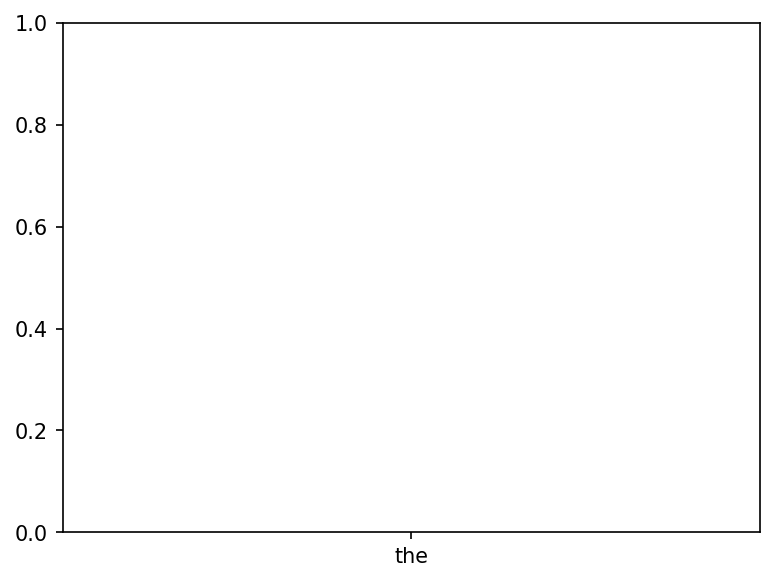

In [50]:
length_histogram_plot(text_freq, cut_off=100, x_label_text='count', salient_data=False)

In [35]:
def zipf_plot_word_freq(rank: np.ndarray, freq: np.ndarray):
    """A zipf distribution plot of the word frequency

    Parameters
    ----------
    rank : np.ndarray
        The rank of the words with 1 being most common
    freq : np.ndarray
        The frequency of occurance or count
    """

    # make the zipf plot, with log scale
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.14, 4.5))
    ax.plot(rank, freq, color=colour_pallet("red"))
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Rank")
    ax.set_xscale("log")
    ax.set_yscale("log")

    # plot the figure
    plt.show()

In [46]:
zipf_plot_word_freq(text_freq)

TypeError: zipf_plot_word_freq() missing 1 required positional argument: 'freq'

In [37]:
def time_plot(t: np.ndarray, y: np.ndarray, t_range: list, y_label_text: str):
    """A plot of the time dependend variable

    Parameters
    ----------
    t : np.ndarray
        an array of the times
    y : np.ndarray
        an array of the y-values
    t_range : list
        a list of the time range to plot
    y_label_text : str
        a y axis label to attach
    """

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.14, 4.5))
    ax.plot(t, y, color=colour_pallet("red"))
    ax.set_xlim(t_range)
    ax.set_xlabel("Time")
    ax.set_ylabel(y_label_text)

    # plot the figure
    plt.show()

In [38]:
def rank_scatter_plot(
    rank_array_1: np.ndarray,
    rank_array_2: np.ndarray,
    rank_array_1_label: str,
    rank_array_2_label: str,
    equal_aspect: bool = True,
    scale: str = "linear",
):
    """Plot of the ranks of two different models
    Additional options to plot different scales and also parity lines

    Parameters
    ----------
    rank_array_1 : np.ndarray
        ranks of model 1
    rank_array_2 : np.ndarray
        ranks of model 2
    rank_array_1_label : str
        textual description of model 1
    rank_array_2_label : str
        textual description of model 2
    equal_aspect : bool, optional
        if x and y scale should be the same
        and a dashed line for parity, by default True
    scale : str, optional
        type of scale to be used on each axis.
        Choices are "linear", "loglog", "logx", "logy", by default "linear"
    """

    # make the plot a count plot, with the number of bins set above
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5), dpi=150)

    ax.plot(
        rank_array_1,
        rank_array_2,
        color=colour_pallet("red"),
        linestyle="None",
        marker="o",
        alpha=0.3,
    )

    ax.set_xlabel(rank_array_1_label)
    ax.set_ylabel(rank_array_2_label)

    if equal_aspect is True:
        ax.set_aspect("equal")
        parity_line = np.array([0, max([np.max(rank_array_1), np.max(rank_array_2)])])
        ax.plot(
            parity_line,
            parity_line,
            color=colour_pallet("teal"),
            linestyle="--",
            alpha=0.8,
        )
    else:
        ax.set_aspect("auto")

    # set the x and y scales
    if scale == "loglog":
        xscale = "log"
        yscale = "log"

    elif scale == "logx":
        xscale = "log"
        yscale = "linear"

    elif scale == "logy":
        xscale = "linear"
        yscale = "log"
    else:
        xscale = "linear"
        yscale = "linear"

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    # plot the figure
    plt.show()

In [39]:
def fraction_histogram_plot(
    length_array: np.ndarray,
    cut_off: int,
    x_label_text: str,
    bin_size: float = 0.1,
    normalize: bool = True,
    min_cut_off: int = 0,
):
    """Plotting histograms where we have non interger input bins

    Parameters
    ----------
    length_array : np.ndarray
        Array of lengths
    cut_off : int
        upper bound cutoff
    x_label_text : str
        text for the x axis
    bin_size : float, optional
        size of the bin width, by default 0.1
    normalize : bool, optional
        normalise the area, by default True
    min_cut_off : int, optional
        set minimum cutoff, by default 0
    """

    # create a list of bins
    min_edge = min_cut_off
    num_bins = int((cut_off - min_edge) / bin_size)
    num_bins_plus_1 = num_bins + 1
    bin_list = np.linspace(min_cut_off, cut_off, num_bins_plus_1)

    # make the plot a count plot, with the number of bins set above
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5), dpi=150)
    ax.hist(length_array, density=normalize, bins=bin_list, color=colour_pallet("teal"))

    if normalize:
        ax.set_ylabel("Count [%]")
    else:
        ax.set_ylabel("Count")

    ax.set_xlabel(x_label_text)

    ax.set_xlim([min_edge, cut_off])

    # plot the figure
    plt.show()